# Chapter 4 Study
# Further Research on the full MNIST dataset

In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Data Gathering

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [5]:
(path/'training').ls()

(#10) [Path('training/9'),Path('training/0'),Path('training/7'),Path('training/6'),Path('training/1'),Path('training/8'),Path('training/4'),Path('training/3'),Path('training/2'),Path('training/5')]

In [6]:
(path/'testing').ls()

(#10) [Path('testing/9'),Path('testing/0'),Path('testing/7'),Path('testing/6'),Path('testing/1'),Path('testing/8'),Path('testing/4'),Path('testing/3'),Path('testing/2'),Path('testing/5')]

## Peek at the data

In [7]:
threes = (path/'training'/'3').ls().sorted()

In [8]:
three_tensors = [tensor(Image.open(o)) for o in threes]

In [9]:
three_tensors[1].size()

torch.Size([28, 28])

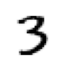

In [10]:
show_image(three_tensors[1]);

## Prepare the data

Generally, when working with floats we want the data to be between 0 and 1 thus we will divide each by 255 to do this. Moreover, we need to stack our images into a nice rank 3 tensor for our model. For example:

In [11]:
stacked_threes = torch.stack(three_tensors).float()/255

In [12]:
stacked_threes.size() # 6131 images of 28 pixel width and 28 pixel length.

torch.Size([6131, 28, 28])

In [13]:
stacked_threes.ndim # rank 3

3

In [14]:
def get_data(num, data='training'):
    nums = (path/data/num).ls().sorted()
    num_tensors = [tensor(Image.open(o)) for o in nums]
    return torch.stack(num_tensors).float()/255

In [15]:
get_data('8')[0][8:16, 8:16]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8118, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3294, 0.9804, 0.9804],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3098, 0.8824, 0.9882, 0.7882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3804, 0.9882, 0.9882, 0.4745],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5804, 0.9882, 0.5569, 0.7176],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8510, 0.9882, 0.9686, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8549, 0.9922, 0.9922, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.2392, 0.9294, 0.9882, 0.9882, 0.9451]])

### Training set:

In [16]:
training = [get_data(str(i)) for i in range(10)]

In [17]:
train_x = torch.cat(training).view(-1, 28*28)

In [18]:
labels = []
for n, x in enumerate(training):
    labels += [n]*len(x)
train_y = tensor(labels).unsqueeze(1)

In [19]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [20]:
# 60000 images, 28*28 (784) pixels
# 60000 labels

In [21]:
train_x[0].shape # first digit image

torch.Size([784])

### Validation set:

In [22]:
testing = [get_data(str(i), data='testing') for i in range(10)]

In [23]:
valid_x = torch.cat(testing).view(-1, 28*28)

In [24]:
labels = []
for n, x in enumerate(testing):
    labels += [n]*len(x)
valid_y = tensor(labels).unsqueeze(1)

In [25]:
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [26]:
# valid_x: 10000 images, 28*28 (784) pixels
# valid_y: 10000 labels

Emulating the PyTorch dataset:

In [27]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))

In [28]:
dl = DataLoader(train_dset, batch_size=256)
xb,yb = first(dl) # Take a sample for example
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [29]:
valid_dl = DataLoader(valid_dset, batch_size=256)

## Training

### 1. Initialise weights

In [32]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [33]:
weights = init_params((28*28,10))
bias = init_params(10)

In [34]:
weights, bias

(tensor([[ 0.9007, -2.1055,  0.6784,  ..., -0.4780, -0.3925, -1.4036],
         [-0.7279, -0.5594, -0.7688,  ...,  0.4396, -0.7581,  1.0783],
         [ 0.8008,  1.6806,  0.3559,  ...,  0.0418, -0.2516,  0.8599],
         ...,
         [ 1.2942,  0.1953, -1.7753,  ...,  0.3531,  0.4474,  0.7192],
         [-1.9300,  0.9975, -1.1493,  ...,  0.2528,  0.2169,  0.4700],
         [-0.7612,  2.3327, -0.1827,  ..., -1.9951,  0.8147, -1.7958]], requires_grad=True),
 tensor([-0.4355, -0.4923, -0.4835, -0.4625,  0.0382, -0.2309, -0.2454, -0.4351, -0.4533, -0.1592], requires_grad=True))

### 2. Make predictions

In [35]:
batch_x, batch_y = xb[:4], yb[:4]
batch_x.shape, batch_y.shape

(torch.Size([4, 784]), torch.Size([4, 1]))

#### Out of the box with Torch

In [36]:
t_linear = nn.Linear(784, 10, bias=True)

In [37]:
t_linear.weight.shape, t_linear.weight.mean(), t_linear.bias

(torch.Size([10, 784]),
 tensor(-0.0002, grad_fn=<MeanBackward0>),
 Parameter containing:
 tensor([ 0.0133, -0.0342, -0.0138, -0.0245,  0.0152, -0.0251,  0.0277,  0.0087,  0.0219, -0.0233], requires_grad=True))

In [38]:
t_output = t_linear(batch_x)
t_output.shape

torch.Size([4, 10])

In [39]:
t_output[0]

tensor([-0.0058,  0.2581,  0.1805, -0.0618, -0.0244, -0.0693,  0.3346, -0.1383,  0.2380, -0.1101], grad_fn=<SelectBackward>)

In [40]:
t_preds = torch.argmax(t_output, dim=1)
t_preds.shape

torch.Size([4])

Predicted: 6
Actual: 0


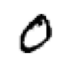

In [43]:
print(f'Predicted: {t_preds[0]}')
print(f'Actual: {batch_y[0].item()}')
show_image(batch_x[0].view(-1, 28, 28));

#### Linear layer from scratch

In [44]:
def linear1(xb): return xb@weights + bias

In [45]:
output = linear1(batch_x)
output.shape

torch.Size([4, 10])

In [46]:
preds = torch.argmax(output, dim=1)
preds.shape

torch.Size([4])

Predicted: 7
Actual: 0


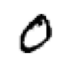

In [47]:
print(f'Predicted: {preds[0]}')
print(f'Actual: {batch_y[0].item()}')
show_image(batch_x[0].view(-1, 28, 28));

In [48]:
correct = (preds == batch_y.squeeze())
correct # None :(

tensor([False, False, False, False])

In [49]:
accuracy = correct.sum().float() / float(batch_y.squeeze().size(0))
print(accuracy)

tensor(0.)


### 3. Calculate the loss

In [50]:
# Softmax + NLL Loss is the way to go when it comes to having more than two classes.

In [51]:
sm_acts = torch.softmax(t_output, dim=1) # using PyTorch
sm_acts.shape

torch.Size([4, 10])

In [52]:
sm_acts[0]

tensor([0.0923, 0.1202, 0.1112, 0.0873, 0.0906, 0.0866, 0.1298, 0.0809, 0.1178, 0.0832], grad_fn=<SelectBackward>)

In [53]:
from torch import exp
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True) # 

In [54]:
my_sm_acts = softmax(t_output)
my_sm_acts.shape

torch.Size([4, 10])

In [58]:
my_sm_acts[0]

tensor([0.0923, 0.1202, 0.1112, 0.0873, 0.0906, 0.0866, 0.1298, 0.0809, 0.1178, 0.0832], grad_fn=<SelectBackward>)

In [59]:
torch.sum(sm_acts, dim=1) 
# Softmax produces a probability for each class with all activations adding to 1 for each input.

tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [60]:
targ = batch_y.squeeze()
F.nll_loss(sm_acts, targ, reduction='none') 
# However, this is misleading given that Torch doesn't take the log for you.
# Instead to do softmax, and true NLL, we use CrossEntropyLoss.

tensor([-0.0923, -0.0872, -0.0969, -0.0906], grad_fn=<NllLossBackward>)

In [61]:
# NLL Loss is misleading in Torch with it not actually taking the log like we need. Instead,
# CrossEntropyLoss takes scare of all the steps for us.

In [62]:
loss_func = nn.CrossEntropyLoss()

In [63]:
loss = loss_func(sm_acts, targ)
loss

tensor(2.3110, grad_fn=<NllLossBackward>)

### 4. Calculate the gradient

In [64]:
loss.backward()
# weights.grad.shape, weights.grad.mean(), bias.grad

In [65]:
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-4.6566e-11),
 tensor([-0.0835,  0.0116,  0.0112,  0.0070,  0.0093,  0.0072,  0.0109,  0.0086,  0.0104,  0.0071]))

In [66]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()

In [67]:
calc_grad(batch_x, targ, t_linear)
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-7.8307e-10),
 tensor([-0.9917,  0.1345,  0.1313,  0.0861,  0.1115,  0.0879,  0.1279,  0.1028,  0.1232,  0.0864]))

In [68]:
# Opps the gradients have changed because we have not bothered to clear them at the end of the previous batch.
calc_grad(batch_x, targ, t_linear)
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-1.5357e-09),
 tensor([-1.8999,  0.2574,  0.2514,  0.1652,  0.2136,  0.1687,  0.2448,  0.1971,  0.2360,  0.1657]))

### 5. Step the weights

Putting it all together.

In [69]:
t_linear.weight.data -= t_linear.weight.grad * 0.0001
t_linear.bias.data -= t_linear.bias.grad * 0.0001

To ensure we don't update any lingering gradients between batches, we need to zero out the currently stored gradients before we move on to the next batch.

In [70]:
t_linear.weight.grad.zero_()
t_linear.bias.grad.zero_();

### 6. & 7. Repeat until you want to stop

In [47]:
def batch_accuracy(xb, yb):
    labels = yb.squeeze()
    preds = torch.argmax(xb, dim=1)
    correct = (preds == labels)
    return correct.float().mean()

In [79]:
lr = 1.
def train_epoch(model):
    model.train()
    for xb,yb in dl:
        # I don't like calc_grad(xb, yb, model) for the book, instead let's unpack it:
        output = model(xb) # 2. Make predictions
        loss = loss_func(output, yb.squeeze()) # 3. Calculate loss 
        loss.backward() # 4. Calculate gradients (dW/dx)
        for p in model.parameters():  
            p.data -= p.grad.data * lr # 5a. Step the weights
        for p in model.parameters():
            p.grad = None  # 5b. Zero gradients

In [80]:
def validate_epoch(model):
    model.eval()
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [81]:
model = nn.Linear(784, 10, bias=True)
for i in range(10):
    train_epoch(model)
    print(validate_epoch(model))

0.1292
0.2441
0.2865
0.3565
0.3801
0.4003
0.4106
0.419
0.4271
0.4329


Woohoo!

## Getting serious with layers and activations

#### Architecture

In [78]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,10),
)

Adding non-linearities

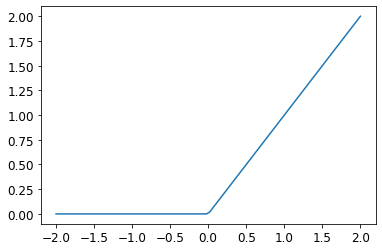

In [79]:
plot_function(F.relu)

#### Optimizer

In [80]:
lr = 1.

In [81]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [82]:
opt = BasicOptim(simple_net.parameters(), lr=0.0001)

In [83]:
sgd_opt = SGD(simple_net.parameters(), lr=0.1)

In [84]:
loss_func = nn.CrossEntropyLoss()

#### Training

In [85]:
# New pipeline with Optim
def train_epoch(model, opt):
    model.train()
    for xb,yb in dl:
        # I don't like calc_grad(xb, yb, model) for the book, instead let's unpack it:
        output = model(xb) # 2. Make predictions
        loss = loss_func(output, yb.squeeze()) # 3. Calculate loss 
        loss.backward() # 4. Calculate gradients (dW/dx)
        opt.step()
        opt.zero_grad()

In [86]:
def validate_epoch(model):
    model.eval()
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [87]:
def train_model(model, epochs):
    for e in range(epochs):
        train_epoch(model, sgd_opt)
        print(validate_epoch(model), end=' ')

In [88]:
train_model(simple_net, 100)

0.122 0.122 0.1595 0.2059 0.2521 0.2845 0.2653 0.2751 0.2908 0.2567 0.2539 0.2676 0.2546 0.2549 0.3524 0.3849 0.4047 0.3798 0.3794 0.3589 0.3603 0.3816 0.3553 0.3712 0.3564 0.3218 0.3547 0.3937 0.3928 0.3871 0.425 0.4711 0.4842 0.503 0.4736 0.4623 0.488 0.4726 0.4955 0.5233 0.53 0.5261 0.5093 0.5154 0.5636 0.6062 0.6166 0.624 0.6286 0.6433 0.6631 0.6787 0.6862 0.6922 0.6915 0.6966 0.7014 0.6977 0.6911 0.6852 0.6842 0.6842 0.6882 0.6961 0.7077 0.7146 0.7229 0.7289 0.7304 0.7339 0.7379 0.7402 0.7378 0.741 0.7403 0.7406 0.742 0.7432 0.7422 0.7394 0.7381 0.7373 0.7379 0.7386 0.7396 0.7413 0.7456 0.7497 0.7533 0.7596 0.7645 0.7714 0.7762 0.7807 0.7858 0.79 0.7923 0.7948 0.8 0.8041 

Predicted: 0
Actual: 0


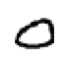

In [98]:
simple_net.eval()
n_b = 5
v_xb,v_yb = first(valid_dl)
output = simple_net(v_xb)
preds = torch.argmax(output, dim=1)
print(f'Predicted: {preds[n_b]}')
print(f'Actual: {v_yb[n_b].item()}')
show_image(v_xb[n_b].view(-1, 28, 28));